<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rotationally-invariant VAE: Application to arbitrary rotated 2D images


---

This notebook demonstrates how to apply a rotationally-invariant variational autoencoder (VAE) to the arbitrary rotated images of handwritten digits.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [ ]:
#@title Installation
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git
# install Kornia library (for image transformations)
!pip install -q kornia

In [4]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

tt = torch.tensor

In [5]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.geometry.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [6]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

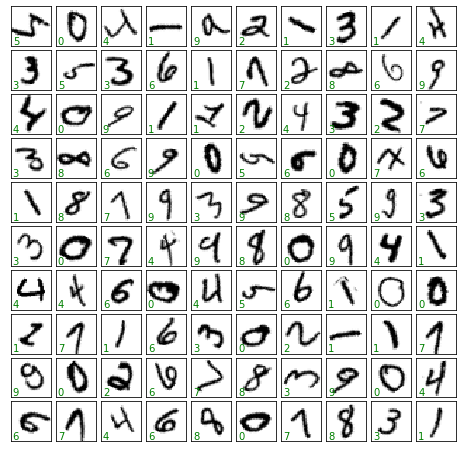

In [7]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.argmax().item()),
            transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [8]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 225.2608
Epoch: 2 Training loss: 192.4384
Epoch: 3 Training loss: 186.4442
Epoch: 4 Training loss: 182.7192
Epoch: 5 Training loss: 180.4038
Epoch: 6 Training loss: 178.6122
Epoch: 7 Training loss: 177.1590
Epoch: 8 Training loss: 175.8830
Epoch: 9 Training loss: 174.6971
Epoch: 10 Training loss: 173.7066
Epoch: 11 Training loss: 172.8370
Epoch: 12 Training loss: 172.0518
Epoch: 13 Training loss: 171.4557
Epoch: 14 Training loss: 170.8372
Epoch: 15 Training loss: 170.3704
Epoch: 16 Training loss: 169.8397
Epoch: 17 Training loss: 169.3922
Epoch: 18 Training loss: 169.0596
Epoch: 19 Training loss: 168.6997
Epoch: 20 Training loss: 168.4193
Epoch: 21 Training loss: 168.1064
Epoch: 22 Training loss: 167.8307
Epoch: 23 Training loss: 167.5953
Epoch: 24 Training loss: 167.3725
Epoch: 25 Training loss: 167.0923
Epoch: 26 Training loss: 166.8603
Epoch: 27 Training loss: 166.6719
Epoch: 28 Training loss: 166.4874
Epoch: 29 Training loss: 166.2943
Epoch: 30 Training loss

Visualize the learned latent manifold:

In [9]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

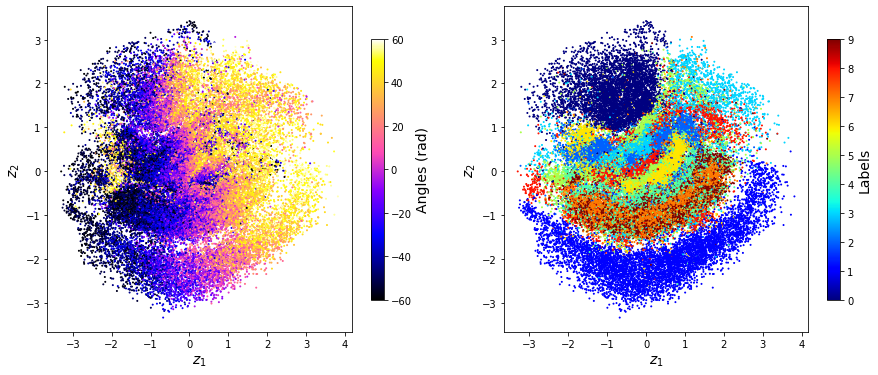

In [10]:
z_mean, z_sd = vae.encode(train_data)
_, labels = torch.max(train_labels, 1)
labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

The examination of latent space shows that the angle changes along the first latent direction, whereas the digit changes mostly along the second latent dimension. This clearly illustrates the disentanglement of the data representation concept, where the rotational angle and class emerge as the two most prominent factors of variation within the data.

Now let's train VAE with rotational invariance (aka rVAE):

In [11]:
# Reinitialize dataloader
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

In [12]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 251.5800
Epoch: 2 Training loss: 206.7223
Epoch: 3 Training loss: 197.0080
Epoch: 4 Training loss: 191.4121
Epoch: 5 Training loss: 187.0545
Epoch: 6 Training loss: 184.2969
Epoch: 7 Training loss: 182.3275
Epoch: 8 Training loss: 180.7379
Epoch: 9 Training loss: 179.4493
Epoch: 10 Training loss: 178.2529
Epoch: 11 Training loss: 177.7237
Epoch: 12 Training loss: 176.5494
Epoch: 13 Training loss: 176.0296
Epoch: 14 Training loss: 175.3076
Epoch: 15 Training loss: 175.0799
Epoch: 16 Training loss: 174.2435
Epoch: 17 Training loss: 173.8404
Epoch: 18 Training loss: 173.6487
Epoch: 19 Training loss: 173.1722
Epoch: 20 Training loss: 172.6439
Epoch: 21 Training loss: 172.2523
Epoch: 22 Training loss: 172.0611
Epoch: 23 Training loss: 171.8164
Epoch: 24 Training loss: 171.3706
Epoch: 25 Training loss: 171.0353
Epoch: 26 Training loss: 170.9686
Epoch: 27 Training loss: 170.5740
Epoch: 28 Training loss: 170.5630
Epoch: 29 Training loss: 170.1028
Epoch: 30 Training loss

Visualize the learned latent manifold:

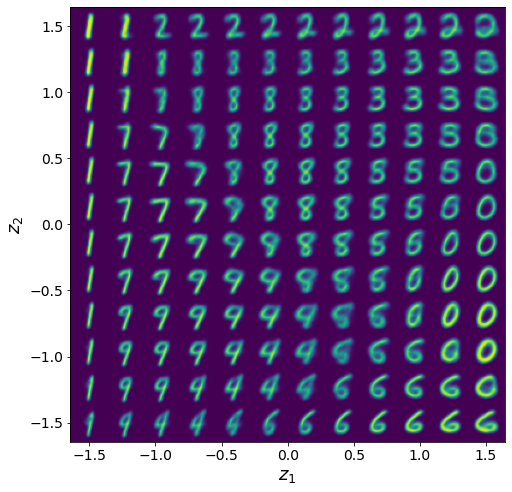

In [13]:
rvae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

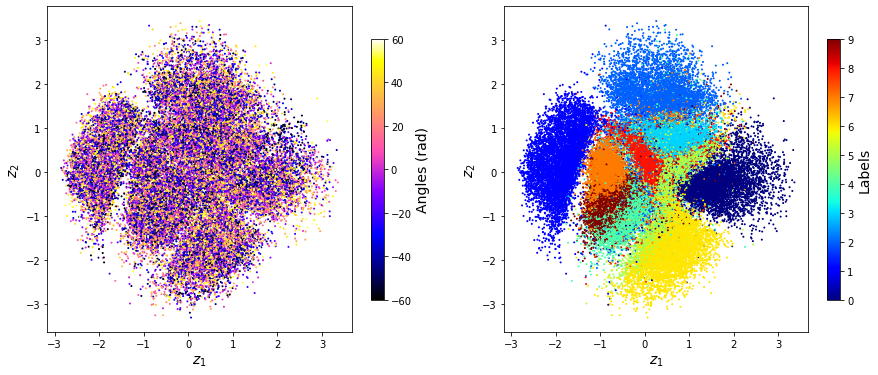

In [14]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In this case, the digits in the latent space are oriented in one direction. The latent space shows that the angles are now random, whereas the digits form well-defined clusters (rather remarkable given that we encode the data set using only two latent variables). We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure above. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person! The latent representation we discovered hence compensated by this fact via introducing it as an additional augmentation variable, and then separating it from other factors of variation.


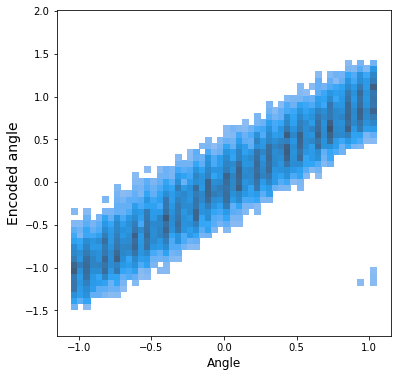

In [15]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z_mean[:, 0], bins=50, pthresh=.1);

Finally, we illustrate the class-conditioned rVAE (crVAE) applied to this data set. Note that the only two things we have to do is add labels to our data loader and specify number of classes (as ```c_dim```) when initializing the crVAE model - pyroVED will take care of the rest.

In [16]:
# Initialize dataloader (here we are adding labels to the training data)
train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)

In [17]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=10, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(crvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 242.8365
Epoch: 2 Training loss: 191.3299
Epoch: 3 Training loss: 179.6475
Epoch: 4 Training loss: 173.5737
Epoch: 5 Training loss: 169.2958
Epoch: 6 Training loss: 166.4848
Epoch: 7 Training loss: 163.6232
Epoch: 8 Training loss: 162.1406
Epoch: 9 Training loss: 161.2008
Epoch: 10 Training loss: 160.3955
Epoch: 11 Training loss: 159.6946
Epoch: 12 Training loss: 159.1265
Epoch: 13 Training loss: 158.7559
Epoch: 14 Training loss: 158.2375
Epoch: 15 Training loss: 157.9815
Epoch: 16 Training loss: 157.6312
Epoch: 17 Training loss: 157.3326
Epoch: 18 Training loss: 156.9870
Epoch: 19 Training loss: 156.7250
Epoch: 20 Training loss: 156.6542
Epoch: 21 Training loss: 156.3124
Epoch: 22 Training loss: 155.9762
Epoch: 23 Training loss: 155.7882
Epoch: 24 Training loss: 155.6232
Epoch: 25 Training loss: 155.3236
Epoch: 26 Training loss: 155.3034
Epoch: 27 Training loss: 154.9580
Epoch: 28 Training loss: 154.7319
Epoch: 29 Training loss: 154.6854
Epoch: 30 Training loss

View the learned latent manifold for each class:

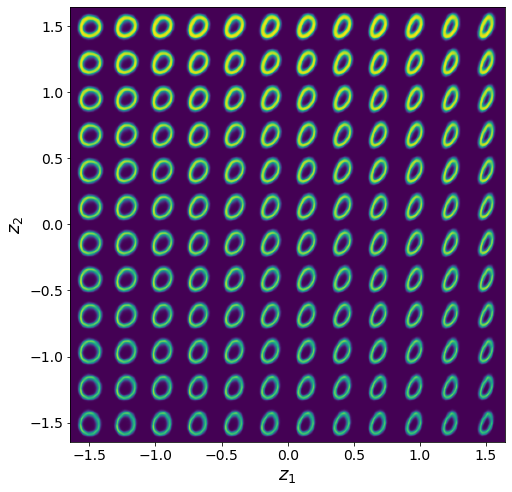

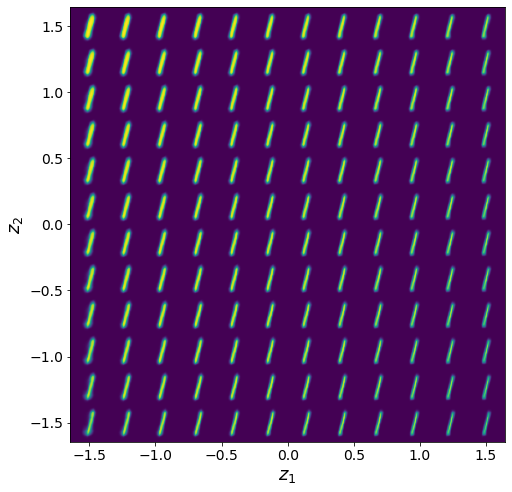

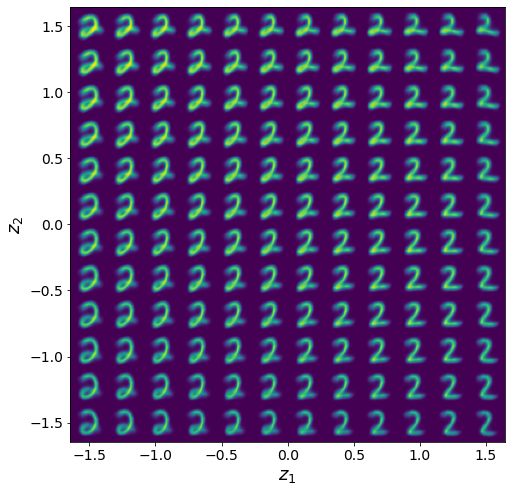

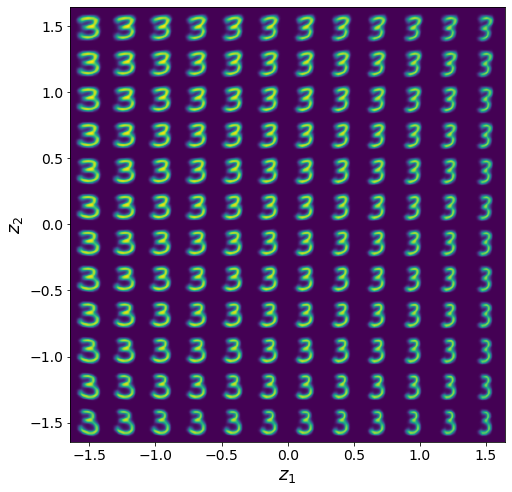

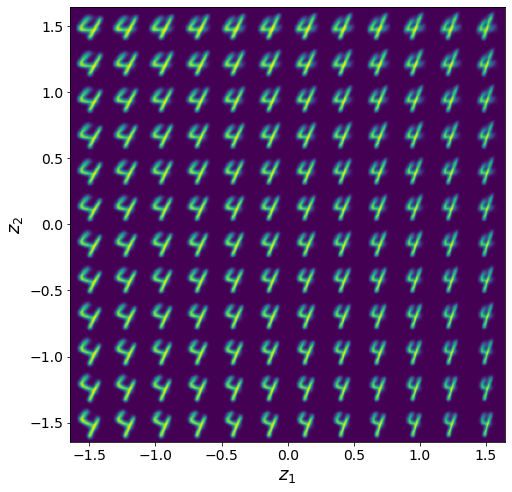

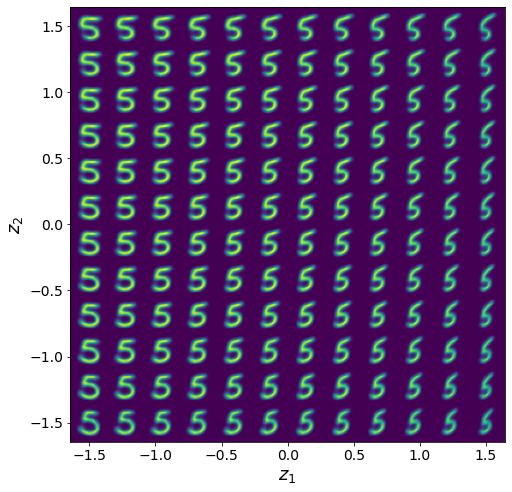

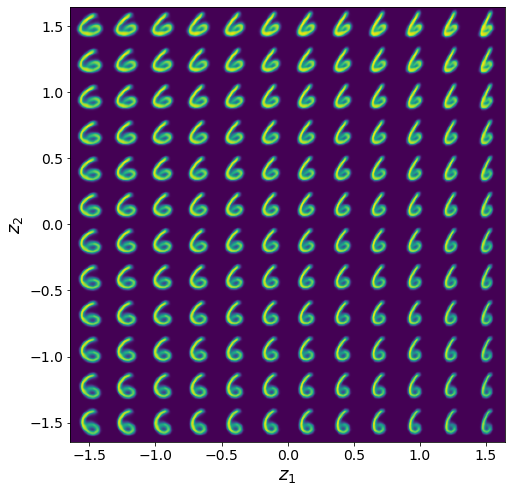

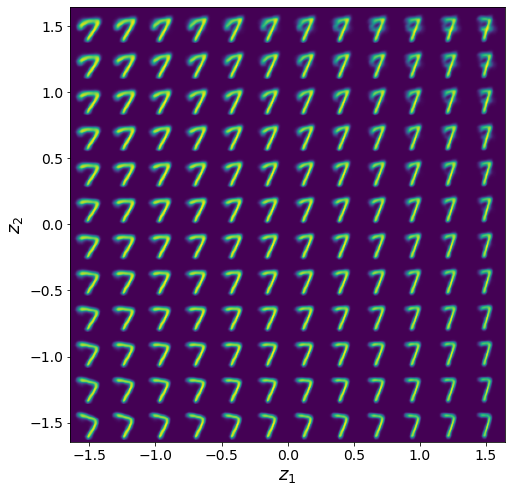

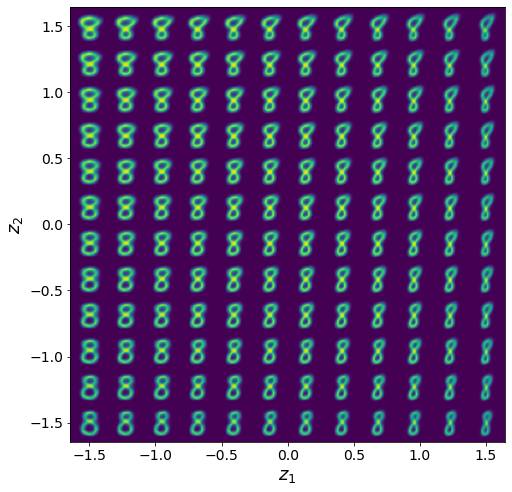

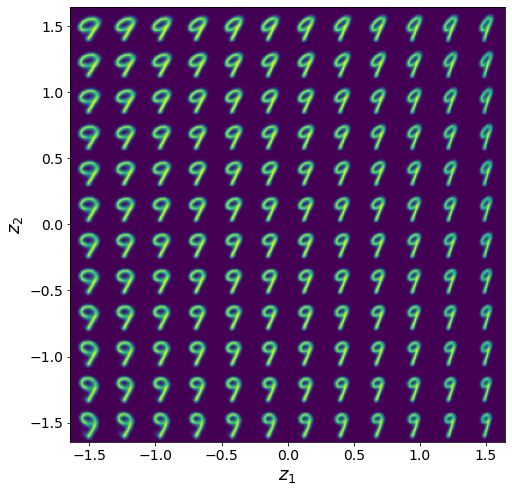

In [18]:
for cls in range(10):
    cls = pv.utils.to_onehot(tt([cls,]), 10)
    crvae.manifold2d(d=12, y=cls, cmap="viridis")

In this case, our latent reconstructions clearly show that within each latent space, the digits are oriented in the same direction, and latent variables now encode very subtle details of the handwriting styles.

Encode all the data and view the encoded values as a scatter plot:

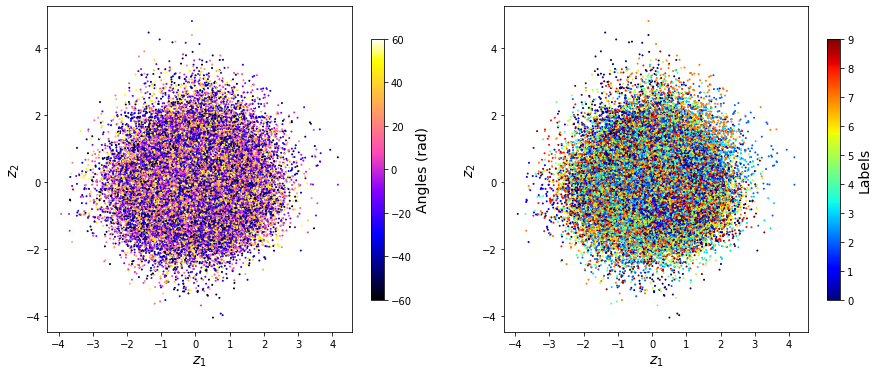

In [19]:
z_mean, z_sd = crvae.encode(train_data, train_labels)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)